# Data processing - Level 1
Code written by Radiance and Yolanda (with the help of ChatGPT)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

In [ ]:
from pathlib import Path

FLIGHT_BASENAME = "2025-02-12_A"

DATA_DIRPATH = Path(r"C:\Users\temel\Desktop\EERL\Campaigns\03_ORACLES\Neumayer_2024\Data")

DATA_FLIGHT_DIRPATH = DATA_DIRPATH / "2024-2025_Sorted" / FLIGHT_BASENAME
DATA_PROCESSING_DIRPATH = DATA_DIRPATH / "Processing"

DATA_LEVEL1_DIRPATH = DATA_PROCESSING_DIRPATH / "Level1"
DATA_LEVEL0_DIRPATH = DATA_PROCESSING_DIRPATH / "Level0"

## Load data

In [4]:
from helikite.metadata.utils import load_parquet

INPUT_DATA_FILE_BASENAME = 'level0_2025-02-12T07-55'

INPUT_FILEPATH = DATA_LEVEL0_DIRPATH / f'{INPUT_DATA_FILE_BASENAME}.csv'

OUTPUT_FILEPATH = DATA_LEVEL1_DIRPATH / f'level1_{FLIGHT_BASENAME}.csv'
OUTLIER_FILEPATH = DATA_LEVEL1_DIRPATH / f'level1_{FLIGHT_BASENAME}_outliers.csv'

df_level0, metadata = load_parquet(DATA_LEVEL0_DIRPATH / f"{INPUT_DATA_FILE_BASENAME}.parquet")

Flight 7 from 2025-11-26 15:23:22 to 2025-11-26 17:10:21

In [ ]:
metadata


**Example commands to output different individual elements of the dataset**  

*To use individual fields, just use the object (.) notation, for example*  
  
print(metadata.flight_date)  
print(metadata.landing_time)  
metadata.takeoff_time

flight_computer_columns = [col for col in df.columns if col.startswith("flight_computer_")]  
print(flight_computer_columns)  

smart_tether_columns = [col for col in df.columns if col.startswith("smart_tether_")]  
print(smart_tether_columns)

## DataProcessor class

In [ ]:
from helikite.classes.data_processing import DataProcessorLevel1, OutputSchemas

data_processor = DataProcessorLevel1(df_level0, metadata, OutputSchemas.TURTMANN)
data_processor.state()

## Outlier removal

To remove outliers, load the level 0 CSV file, making sure to set the index to the DateTime.  
This function will load all the data, plot an individual variable, and then save a CSV of any outliers that are chosen as True. This outlier CSV will be later used by ```data_processor.set_outliers_to_nan()``` to mask the values in the original dataframe.

_Note: No data is changed in the input dataframe._
  
In a first time, check the **'flight_computer_pressure'** against **'flight_computer_time'** as well as **'flight_computer_Out1_T'**, **'flight_computer_Out2_T'**, **'flight_computer_Out1_H'** and **'flight_computer_Out2_H'**.  
Then check **'smart_tether_Wind (m/s)'**. The WD values corresponding to the WS outliers will automatically also be set as outliers – no need to manually select **'smart_tether_Wind (degrees)'** outliers (if ```use_coupled_columns``` is ```True```).
If needed, remove **'flight_computer_Lat'** outliers. The Long values corresponding to the Lat outliers will automatically also be set as outliers – no need to manually select **'flight_computer_Long'** outliers (if ```use_coupled_columns``` is ```True```).

### Coupled columns
To check which columns are coupled, see output of ```data_processor.state()```. To add new groups of coupled columns to an instrument, pass the list of all the groups to argument ```coupled_columns```  of the
instrument instance. For example:
```
flight_computer_v1 = FlightComputerV1(
    name="flight_computer",
    ...
    coupled_columns=[
        ('flight_computer_TEMP1', 'flight_computer_RH1'),
        ('flight_computer_TEMP2', 'flight_computer_RH2'),
    ]
)
```
 For the coupled columns to be updated, restart the kernel and rerun the cells.

In [ ]:
data_processor.choose_outliers(y="flight_computer_pressure", outlier_file=OUTLIER_FILEPATH, use_coupled_columns=True)
# data_processor.choose_outliers(y="pops_pressure", outlier_file=OUTLIER_FILEPATH)
# data_processor.choose_outliers(y="cpc_DateTime", outlier_file=OUTLIER_FILEPATH)

If coupled columns were not specified when choosing outliers, ensure consistency manually.
If coupled columns were specified, this adjustment is applied automatically.

In [8]:
# outliers = pd.read_csv(OUTLIER_FILEPATH, index_col=0, parse_dates=True)
# outliers["smart_tether_Wind (degrees)"] = outliers["smart_tether_Wind (m/s)"]   # Remove WD values corresponding to outlying WS
# outliers["flight_computer_Long"] = outliers["flight_computer_Lat"]              # Remove Long values corresponding to outlying Lat
# outliers.to_csv(OUTLIER_FILEPATH, date_format="%Y-%m-%d %H:%M:%S")              # Save corresponding outliers into the csv file

Column 'flight_computer_Lat' has data present. Skipping fill.
Column 'flight_computer_Long' has data present. Skipping fill.


In [9]:
# Set GPS data in case of missing FC files
data_processor.fillna_if_all_missing({"flight_computer_Lat": 7039.724, "flight_computer_Long": 817.1591})

Outliers file                           /home/rina/Desktop/studies/EPFL/EERL/data/ORACLES/Helikite/2025-2026/Data/Processing/Level1/level1_2025-11-26_A_outliers.csv
Variable                                Number of outliers  
------------------------------------------------------------
flight_computer_Lat                     25                  
flight_computer_Long                    25                  
smart_tether_Wind (degrees)             133                 
smart_tether_Wind (m/s)                 133                 

Completed operations
------------------------------
choose_outliers          
fillna_if_all_missing    



In [10]:
data_processor.state()

In [11]:
# outliers = pd.read_csv(OUTLIER_FILENAME, index_col=0, parse_dates=True)
# df.loc[outliers.index] = df.loc[outliers.index].mask(outliers)

In [ ]:
data_processor.set_outliers_to_nan()
#df.loc["2025-02-15 09:47:40":"2025-02-15 09:47:50", 'smart_tether_Wind (m/s)']   # Print time range to control if values replaced by NaN

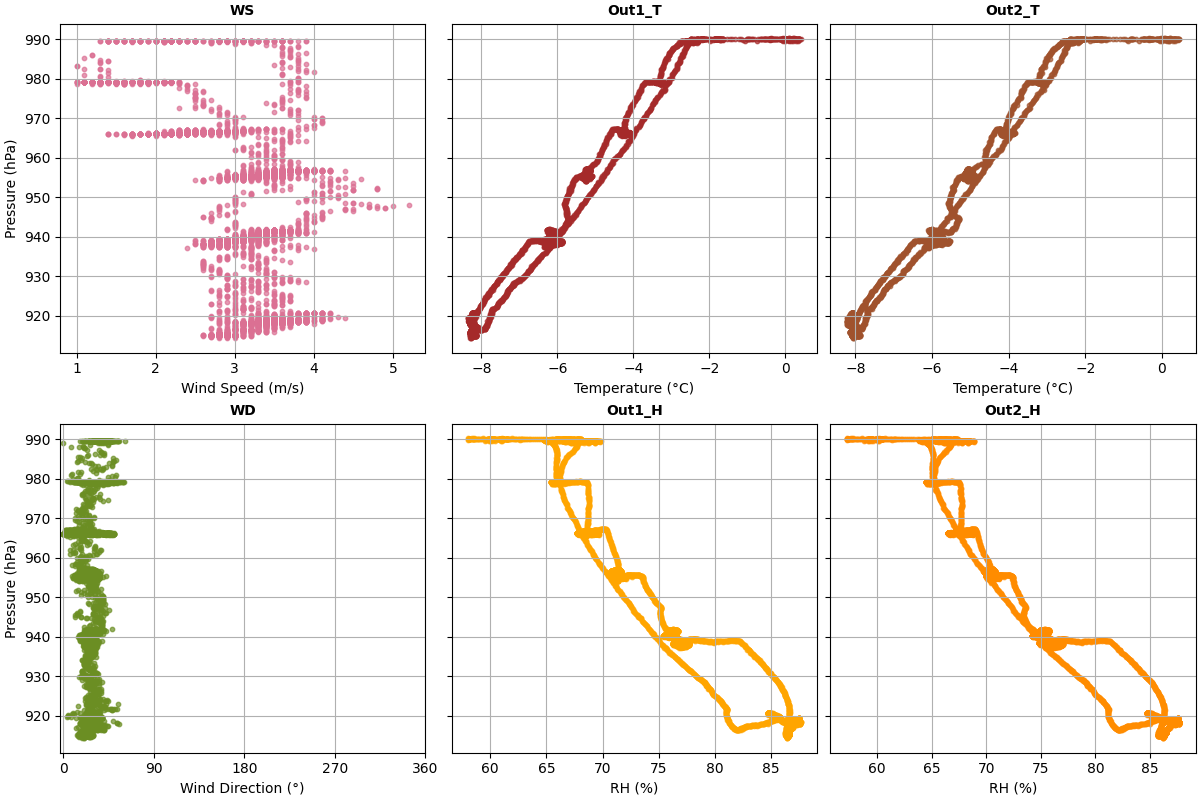

In [12]:
# TODO
# df['flight_computer_pressure'] = df['pops_pressure']

### Outlier removal double check
Plot variables with possible removed outliers.

In [13]:
data_processor.plot_outliers_check()

Check position of balloon compared to the station based on GPS coordinates.  

Transformation of degrees-minutes coordinates (DM) into decimal degrees (DD) coordinates.  
Addition of 'latitude_dd' and 'longitude_dd' into df.

Number of NaNs - flight_computer_Out1_T: 0 flight_computer_Out2_T: 0
Number of NaNs - flight_computer_Out1_H: 0 flight_computer_Out2_H: 0
Saving figure to: /home/rina/Desktop/studies/EPFL/EERL/data/ORACLES/Helikite/2025-2026/Data/Processing/Level1/Level1_2025-11-26_A_T_RH_averaging.png


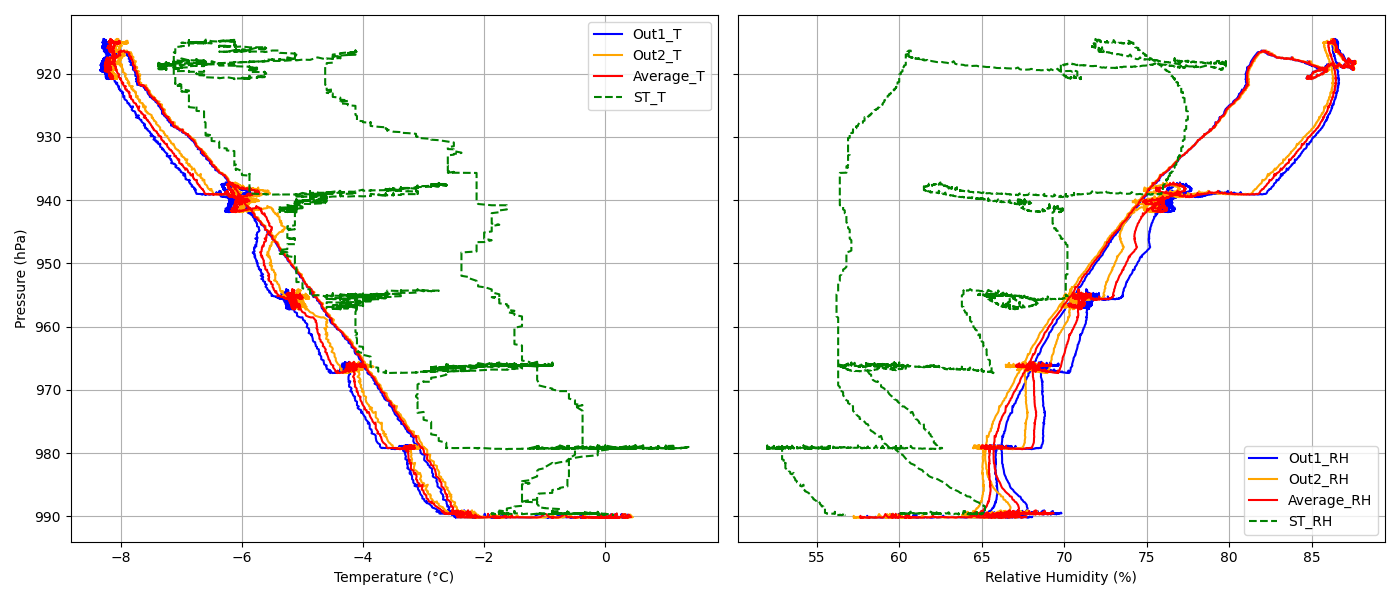

In [14]:
data_processor.plot_gps_on_map()

## T and RH averaging

Averages flight computer temperature and humidity data from the two T/RH sensors.
If > K NaNs for one of the sensors, takes only the other one into account, where K is a NaN threshold, which can be specified in `T_RH_averaging`.

Plots T and RH as a function of pressure.
Smart Tether is also plotted as an indication but not taken into account for the averaging.

Adds 'Average_Temperature' and 'Average_RH' into df.

In [ ]:
# if columns are not specified, takes the default flight computer columns
data_processor.T_RH_averaging(columns_t=None, columns_rh=None, nan_threshold=400)
data_processor.plot_T_RH(save_path=constants.LEVEL1_DIRPATH / f"Level1_{constants.FLIGHT_BASENAME}_T_RH_averaging.png")

**In case the standard T and RH averaging is not working, and the ST measurements need to be taken into account, update the cell above by:**

Applying any required corrections to the smart tether T and RH measurements.
```
data_processor.df['smart_tether_T (deg C)_corr'] = data_processor.df['smart_tether_T (deg C)'].ffill().bfill() - 0.2
data_processor.df['smart_tether_%RH_corr'] = data_processor.df['smart_tether_%RH'].ffill().bfill() - 6.1
```

Specifying the columns to average in the function call, including smart tether T and RH measurements:
```
data_processor.T_RH_averaging(
    columns_t=['flight_computer_Out1_T', 'flight_computer_Out2_T', 'smart_tether_T (deg C)_corr'],
    columns_rh=['flight_computer_Out1_H', 'flight_computer_Out2_H', 'smart_tether_%RH_corr'],
    nan_threshold=400,
)
```

## Altitude calculation 

Adds 'DateTime', 'Pressure_ground', 'Temperature_ground' and 'Altitude' into df.

In [ ]:
data_processor.altitude_calculation_barometric()
data_processor.df.head()

**When start and/or stop of FC at balloon height and not on the sledge : add 3.5 m**

In [ ]:
# TODO
import matplotlib.pyplot as plt

if False:
    df['Altitude'] = df['Altitude'] + 3.5

    plt.close('all')
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Altitude'], label='Altitude')
    plt.xlabel('Time')
    plt.ylabel('Altitude (m)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Processing missing instruments
**If no measurements are available for an instrument, add columns with NaNs into the dataset.**

In [ ]:
data_processor.add_missing_columns()

## CO2 data processing

In [ ]:
data_processor.process_CO2_STP()

## STAP data processing

In [ ]:
data_processor.STAP_STP_normalization()

## POPS data processing
### POPS total concentration calculation

Calculate the total concentration and dN/dlogDP for each bin

From Pohorsky et al. (2024) it appeared that particles with diameters between 142 and 186 (bins 0 to 2) are wrongly detected by the POPS as total particle concentration increases. This phenomenon can be explained by electronic noise from the detector, where fringes on the edge of the Gaussian signal are perceived as smaller particles by the software. It was therefore decided to only consider data for particles larger than 186 nm as the error induced by the first three bins is too high.

*dN_pops = pops_bX / popsflow_mean = dN*  
*pops_total_conc = sum of dN_pops*  
*pops_bX_dlogDp = dN/dlogDp*  

Adds 'pops_total_conc' and 'pops_bX_dlogDp' into df.

In [ ]:
data_processor.POPS_total_conc_dNdlogDp()

**Apply in case of POPS outlier to replace by NaN at a specific timestamp**

In [ ]:
if False:
    pops_b_cols = [col for col in df.columns if col.startswith('pops_b')]
    cols_to_nan = pops_b_cols + ['pops_total_conc']

    timestamp = pd.Timestamp("2025-02-12 07:57:25")
    df.loc[timestamp, cols_to_nan] = np.nan

**Apply in case of intervals with POPS measurements = 0**  

In [ ]:
import matplotlib.dates as mdates
from matplotlib.widgets import Button
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Suppress all warnings
warnings.filterwarnings("ignore")

%matplotlib widget
plt.close('all')

# Plot setup
fig, ax = plt.subplots(figsize=(10, 4))
palette = ["#F54B0F", "#415067"]

ax.plot(data_processor.df.index, data_processor.df["pops_total_conc"], color=palette[0], linewidth=2)
ax.grid(True, ls="--", alpha=0.5)
ax.set_ylim(-5, 400)
ax.set_ylabel("POPS_total_conc (/cm3)")
ax.set_xlabel("Time")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Interaction logic
selected_points = []
stable_periods = []
span_artists = []

def onclick(event):
    if event.inaxes != ax:
        return

    # Skip if zoom or pan mode is active
    if plt.get_current_fig_manager().toolbar.mode != '':
        return
        
    click_time = mdates.num2date(event.xdata)
    selected_points.append(click_time)

    ax.plot(event.xdata, event.ydata, 'o', color=palette[1], markersize=8)
    fig.canvas.draw()

    if len(selected_points) == 2:
        start, end = sorted(selected_points)
        stable_periods.append((start, end))
        span = ax.axvspan(start, end, color=palette[1], alpha=0.2)
        span_artists.append(span)
        selected_points.clear()
        fig.canvas.draw()
results_df = None

def finish_selection(event):
    global results_df

    if stable_periods:
        results_df = pd.DataFrame(stable_periods, columns=['Start_Time', 'End_Time'])
        results_df['Duration'] = results_df['End_Time'] - results_df['Start_Time']
        
        # Optional formatting
        results_df['Start_Time'] = results_df['Start_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
        results_df['End_Time'] = results_df['End_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

        print("\nSelected Stable Periods:")
        print(results_df.to_string(index=False))

        # Copy to clipboard
        results_df.to_clipboard(index=False)
        print("\nResults copied to clipboard!")
    else:
        print("No stable periods selected")

# Add button
ax_button = plt.axes([0.82, 0.01, 0.15, 0.05])
btn = Button(ax_button, 'Finish Selection', color='lightgoldenrodyellow')
btn.on_clicked(finish_selection)

# Hook up click handler
fig.canvas.mpl_connect('button_press_event', onclick)

plt.title("Click to select stable periods")
plt.show()

print(results_df)

In [25]:
results_df

In [ ]:
if False:
    # Save or load pops mask csv
    results_df.to_csv(DATA_LEVEL1_DIRPATH / f"Level1_{metadata.flight_date}_Flight_{metadata.flight}_POPSmask.csv", index=False)
    # results_df = pd.read_csv(DATA_LEVEL1_DIRPATH / f"Level1_{metadata.flight_date}_Flight_{metadata.flight}_POPSmask.csv")

    # Mask pops data in selected time interval
    pops_cols = [f'pops_b{i}_dlogDp' for i in range(16)] + ['pops_total_conc']

    for _, row in results_df.iterrows():
        start = row['Start_Time']
        end = row['End_Time']
        mask = (df.index >= start) & (df.index <= end)
        df.loc[mask, pops_cols] = np.nan

    df.loc["2025-02-10 13:47:00":"2025-02-10 13:47:15", 'pops_b3_dlogDp']

### Normalization of POPS concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  


       
Adds 'pops_total_conc_stp' and 'pops_bX_dlogDp_stp' into df.

In [ ]:
data_processor.POPS_STP_normalization()

### Plot POPS size distribution and total concentration  

STP normalized bin concentrations and total concentration

In [ ]:
from helikite.instruments.pops import plot_pops_distribution

plot_pops_distribution(data_processor.df, time_start=None, time_end=None)

## mSEMS data processing
### mSEMS total concentration calculation

*msems_inverted_Bin_ConcX = dN/dlogDp*  
*msems_inverted_dN_Bin_ConcX = conc * dlogDp*  
*msems_inverted_dN_totalconc = sum of msems_inverted_dN_Bin_ConcX*  

Adds 'msems_inverted_dN_Bin_ConcX' and 'msems_inverted_dN_totalconc' into df.

In [ ]:
data_processor.mSEMS_total_conc_dN()

### Normalization of mSEMS concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  

Adds 'msems_inverted_Bin_ConcX_stp' and 'msems_inverted_dN_totalconc_stp' to df.

In [ ]:
data_processor.mSEMS_STP_normalization()

### Plot mSEMS size distribution and total concentration

STP normalized bin concentrations and total concentration

In [ ]:
from helikite.instruments.msems import plot_msems_distribution

plot_msems_distribution(data_processor.df, time_start=None, time_end=None)

**Replace no data or flooded mSEMS measurements by NaN**

In [ ]:
import numpy as np

if False:
    # Define time range of "bad" mSEMS measurements
    start_time = "2025-01-27 17:55"
    end_time = "2025-01-27 19:45"

    inverted_cols = [
        col for col in df.columns
        if col.startswith("msems_inverted_") and col != "msems_inverted_DateTime"
    ]

    time_mask = (df.index >= pd.to_datetime(start_time)) & (df.index <= pd.to_datetime(end_time))

    affected_rows = set()

    # Apply only within the time range
    for col in inverted_cols:
        col_mask = df[col].map(lambda x: isinstance(x, (int, float)) and not np.isnan(x))
        full_mask = time_mask & col_mask
        affected_rows.update(df.index[full_mask])
        df.loc[full_mask, col] = np.nan

    # Count affected rows
    print(f"{len(affected_rows)} rows had numeric value replaced by NaN in 'msems_inverted_...' columns within the time range.")

## mCDA data processing
### mCDA bin concentrations, total concentration and normalization per bin width

For bins 1 to 256 :  
*mcda_dataB X = raw counts*  
*mcda_dataB X_dN = counts / (flow rate * sampling interval) = concentration*  
*mcda_dN_totalconc = sum of mcda_dataBX_dN*  
*mcda_dataB X_dN_dlogDp = dN/dlogDp = mcda_dataBX_dN / dlogDp*

Adds 'mcda_dataB X_dN', 'mcda_dN_totalconc' and 'mcda_dataB X_dN_dlogDp' into df.

In [ ]:
data_processor.mcda_concentration_calculations()

### Normalization of mCDA concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  

Adds 'mcda_dataB X_dN_dlogDp_stp' and 'mcda_dN_totalconc_stp' to df.

In [ ]:
data_processor.mCDA_STP_normalization()

### Plot mCDA size distribution and total concentration

STP normalized bin concentrations and total concentration

In [ ]:
from helikite.instruments.mcda_instrument import Midpoint_diameter_list

data_processor.plot_mcda_distribution(Midpoint_diameter_list)

**Vertical droplet size distribution**

In [ ]:
from helikite.instruments.mcda_instrument import Midpoint_diameter_list

data_processor.plot_mcda_vertical_distribution(Midpoint_diameter_list)

## CPC3007 data processing

### Normalization of CPC3007 concentrations to standard temperature and pressure (STP)

at 0°C (273.15 K) and 1 atm (1013.25 hPa).  

$C_{\text{STP}} = C_{\text{measured}} \times \left( \frac{P_{\text{measured}}}{P_{\text{STP}}} \right) \times \left( \frac{T_{\text{STP}}}{T_{\text{measured}}} \right)$  


       
Adds 'CPC_total_N_stp' into df.

In [ ]:
data_processor.CPC_STP_normalization()

## Filter data check

In [ ]:
# NO FILT DATA FROM FC --> READ IN THE FILT FILE AND PASTE IT INTO DF WITH CORRECT NAMES !!!!!

In [ ]:
if False:
    filt = pd.read_csv(DATA_FLIGHT_DIRPATH / "250127A3.TXT", skiprows=13, delimiter='\t')  # or use sep=',' if it's CSV

    date_str = filt['#YY/MM/DD'].str.strip()
    time_str = filt['HR:MN:SC'].str.strip()
    combined = date_str + ' ' + time_str
    filt['datetime'] = pd.to_datetime(combined, format='%y/%m/%d %H:%M:%S')
    filt = filt.set_index('datetime', drop=False)
    filt.columns = 'flight_computer_F_' + filt.columns.astype(str)

    filt

In [ ]:
if False:
    df = df.join(filt, how='left')
    df

In [ ]:
from helikite.processing.post.level1 import filter_data
import matplotlib.pyplot as plt

plt.close('all')
%matplotlib ipympl

if False:
    filter_data(df)

**In case of broken filters, replace filter positions by 1.**

In [ ]:
if False:
    df['flight_computer_F_cur_pos'] = 1
    df['flight_computer_F_pump_pw'] = 0

In [ ]:
if False:
    df.loc[df['flight_computer_F_cur_pos'] == 0, 'flight_computer_F_cur_pos'] = 1
    df.loc[df['flight_computer_F_cur_pos'] == 2, 'flight_computer_F_cur_pos'] = 1
    df.loc[df['flight_computer_F_cur_pos'] == 4, 'flight_computer_F_cur_pos'] = 1

In [ ]:
if False:
    broken_filter_start = pd.Timestamp("2025-02-11 15:44:14")
    broken_filter_end = pd.Timestamp("2025-02-11 16:11:39")
    df.loc[df['flight_computer_F_cur_pos'] == 0, 'flight_computer_F_cur_pos'] = 1

    df.loc[(df.index >= broken_filter_start) & (df.index <= broken_filter_end), 'flight_computer_F_cur_pos'] = 2.0
    df.loc[(df.index >= broken_filter_start) & (df.index <= broken_filter_end), 'flight_computer_F_pump_pw'] = 37.0
    df['flight_computer_F_cur_pos']

## Data quicklooks

In [ ]:
filename = f'Level1_{metadata.flight_date}_A_Flight_{metadata.flight}.png'
save_path = DATA_LEVEL1_DIRPATH / filename
data_processor.plot_flight_profiles(f"{metadata.flight_date}_A", save_path)

In [ ]:
filename = f'Level1_{metadata.flight_date}_A_SizeDistr_Flight_{metadata.flight}.png'
save_path = DATA_LEVEL1_DIRPATH / filename
data_processor.plot_size_distr(save_path)

## Level 1
**Save file containing all the columns (processed)**

In [ ]:
df.to_csv(DATA_LEVEL1_DIRPATH / OUTPUT_FILEPATH, index=True)

# Random code bits
### Remove outliers from the Smart Tether WS and WD datapoints

This is a **sliding-window median filter** used for **outlier detection and removal**.
- Look at a window of neighboring values around each data point (10 neighboring values)
- Compare the current point to the median of this window.
- If the point is significantly different (>35% away from the median), it's treated as an outlier and **replaced with NaN**.

Applied on WS, the corresponding WD datapoints are then also removed.

In [ ]:
from helikite.instruments.smart_tether import wind_outlier_removal
%matplotlib ipympl

df_filtered = wind_outlier_removal(df)

**IF THE FILTER APPLIES CORRECTLY** : save the filtered WS and WD data back into th original dataframe

In [ ]:
# Save the filtered data back into th original dataframe
df['smart_tether_Wind (m/s)'] = df_filtered['smart_tether_Wind (m/s)']
df['smart_tether_Wind (degrees)'] = df_filtered['smart_tether_Wind (degrees)']
print("Filtered data saved to the original dataframe.")

### Metadata dictionary

In [ ]:
# Otherwise, to make a dictionary from the metadata:
metadata_dict = metadata.model_dump()

# Then use it as a normal Python dictionary
metadata_dict['flight_date']

In [ ]:
# The dataframe is unpacked into the 'df' variable from that function above
df

### GPS coordinate check

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 4))

# First y-axis for Longitude
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Longitude', color=color)
ax1.plot(df.index, df['flight_computer_Long'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Second y-axis for Latitude
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Latitude', color=color)
ax2.plot(df.index, df['flight_computer_Lat'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Longitude and Latitude over Time')
plt.show()


In [ ]:


def convert_dm_to_dd(dm_value, direction):
    if pd.isna(dm_value):
        return None
    degrees = int(dm_value / 100)
    minutes = dm_value - degrees * 100
    dd = degrees + minutes / 60
    if direction in ['S', 'W']:
        dd *= -1
    return dd

# Apply conversion to the entire column
df['latitude_dd'] = df['flight_computer_Lat'].apply(lambda x: convert_dm_to_dd(x, 'S'))
df['longitude_dd'] = df['flight_computer_Long'].apply(lambda x: convert_dm_to_dd(x, 'W'))
df['latitude_dd']

### Export TAPIR data for Delphine 

In [ ]:
df['mcda_dN_totalconc_stp'] = np.nan

In [ ]:
# Create a new DataFrame with the same DateTime index as df
df_tapir = df.loc[:, ['Altitude', 'Average_Temperature', 'Temperature_ground', 'mcda_dN_totalconc_stp'] + 
                  [col for col in df.columns if col.startswith('tapir_')]]
df_tapir['Altitude'] = df_tapir['Altitude'].round(2)
df_tapir['Average_Temperature'] = df_tapir['Average_Temperature'].round(2)
df_tapir['mcda_dN_totalconc_stp'] = df_tapir['mcda_dN_totalconc_stp'].round(2)

df_tapir

In [ ]:
import pandas as pd
import os

# Example metadata as a dictionary (you can adjust this to your actual metadata object)
metadata_lines = {
    'Flight date' : metadata.flight_date,
    'Flight number' : metadata.flight,
    'Takeoff time' : metadata.takeoff_time,
    'Landing time' : metadata.landing_time,
    'Average_Temperature (in °C)' : 'average T from two temperature sensors',
    'Temperature_ground (in K)' : 'extrapolated ground temperature based on T at takeoff and landing',
    'mcda_dN_totalconc_stp (cm-3)' : 'droplet total concentration',
    'Note' : 'there are two "peaks" in the temperature profile, I am however not yet sure if they are significant or outliers'
}

# Construct the dynamic filename
filename = f"{metadata.flight_date}_Flight{metadata.flight}_TAPIR.txt"

# Define your output directory (use raw string if needed)
output_dir = 'tapir'

# Combine the path and filename
output_path = os.path.join(output_dir, filename)

# Save the file
with open(output_path, 'w', newline='') as f:
    for key, value in metadata_lines.items():
        f.write(f"# {key}: {value}\n")
    f.write("\n")
    df_tapir.to_csv(f, index=True)

### Export TAPIR data for Delphine 